In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
import html

df_trainvaltest = pd.read_csv("./development.csv", parse_dates='timestamp')
df_eval = pd.read_csv("./evaluation.csv")
df_trainvaltest.values[np.argmax(df_trainvaltest['title'].isna()),:]
df_trainvaltest['title'].dropna(inplace=True)
df_trainvaltest.values[np.argmax(df_trainvaltest['article'].isna()),:]
df_trainvaltest['article'].fillna('',inplace=True)


df_trainvaltest['title'] = df_trainvaltest['title'].str.casefold().str.strip()
df_trainvaltest['article'] =df_trainvaltest['article'].str.lower().str.strip()
df_trainvaltest['source'] =df_trainvaltest['source'].str.casefold().str.strip()

df_trainvaltest.drop_duplicates(subset = 'article', inplace=True)

#df_trainvaltest.loc[df_trainvaltest['article'].str.startswith("read full"),'article'] = ' '

df_trainvaltest['text'] = 2 * df_trainvaltest['title'] + ' ' + df_trainvaltest['article']
mask = df_trainvaltest['label'] == 5

df_trainvaltest['text'] = html.unescape(df_trainvaltest['text'])
X_trainvalvaltest = df_trainvaltest[['text', 'source', 'page_rank']]

X_trainvalvaltest.loc[mask,'text'] = 2 * df_trainvaltest.loc[mask, 'title']  + 3*df_trainvaltest.loc[mask,'article'] 

y_trainvaltest = df_trainvaltest['label']


X_trainval, X_test, y_trainval, y_test = train_test_split(
  X_trainvalvaltest,
  y_trainvaltest,
  test_size= .2,
  random_state=42,
  stratify=y_trainvaltest
)

from sklearn.svm import LinearSVC
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MaxAbsScaler


preprocessor = ColumnTransformer(
    transformers=[
        ('tfidf', TfidfVectorizer(stop_words='english'), 'text'),
        ('source', OneHotEncoder(handle_unknown='ignore'), ['source']),
        #('hour', OneHotEncoder(handle_unknown='ignore'), ['time_slot']),
        ('page_rank', OneHotEncoder(handle_unknown='ignore'), ['page_rank'])
    ]
)
pipe = Pipeline([
  ('preprocessor', preprocessor),
   ('clf', LinearSVC(max_iter=3000, dual=False))
   ])

param_grid = {
    'preprocessor__tfidf__max_features': [15000, 20000, 30000], 
    'preprocessor__tfidf__ngram_range': [ (1,1), (1, 3)],
    'preprocessor__tfidf__binary': [True, False],
    'preprocessor__tfidf__sublinear_tf': [True, False],
    'preprocessor__tfidf__min_df': [1, 2, 5, 10],
    'preprocessor__tfidf__max_df': [.5, .7, .9],
    'clf__C': np.logspace(-1,2,6), # C basso aiuta contro l'overfitting
    'clf__class_weight': ['balanced'],
    #'clf__solver': ['liblinear', 'lbfgs'],
    'clf__penalty': [ 'l1','l2']
}

grid_search = RandomizedSearchCV(
  pipe,
  param_grid,
  n_iter=10,
  cv=3,
  n_jobs=10,
  verbose=3, 
  scoring='f1_macro',
  error_score='raise')
grid_search.fit(X_trainval, y_trainval)

print(grid_search.best_score_, grid_search.best_params_)

best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
print(f1_score(y_test, y_pred, average='macro'))
print(confusion_matrix(y_test, y_pred))

print(classification_report(best_model.predict(X_test), y_test))


/tmp/ipykernel_47762/1800298463.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_trainvaltest['article'].fillna('',inplace=True)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV 1/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.686 total time=  20.3s
[CV 2/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.692 total time=  21.4s
[CV 3/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1

/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.700 total time= 3.1min
[CV 3/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.701 total time= 3.1min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.704 total time= 3.2min
[CV 1/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.610 total time= 1.8min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=1.5848931924611134, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.664 total time= 5.3min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=6.30957344480193, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.625 total time= 6.0min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=6.30957344480193, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.622 total time= 6.1min
[CV 1/3] END clf__C=6.30957344480193, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.622 total time= 6.2min
[CV 2/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.609 total time= 1.5min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.645 total time= 7.0min
[CV 3/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.608 total time= 1.9min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.649 total time= 7.3min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=100.0, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.652 total time= 7.6min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.670 total time= 1.6min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=1.5848931924611134, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.667 total time= 5.6min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.681 total time= 1.8min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.669 total time= 1.8min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=1.5848931924611134, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.9, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.667 total time= 6.3min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=2, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.710 total time= 3.8min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=2, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.714 total time= 4.0min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.681 total time= 1.5min
[CV 3/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=30000, preprocessor__tfidf__min_df=2, preprocessor__tfidf__ngram_range=(1, 3), preprocessor__tfidf__sublinear_tf=True;, score=0.707 total time= 4.0min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.685 total time= 1.4min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=0.1, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=False, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=15000, preprocessor__tfidf__min_df=5, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.678 total time= 1.1min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 1/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.691 total time= 3.1min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 3/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.694 total time= 2.6min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


[CV 2/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l1, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.7, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=10, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=False;, score=0.697 total time= 2.9min


/usr/lib/python3/dist-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


0.7101226593581679 {'preprocessor__tfidf__sublinear_tf': True, 'preprocessor__tfidf__ngram_range': (1, 3), 'preprocessor__tfidf__min_df': 2, 'preprocessor__tfidf__max_features': 30000, 'preprocessor__tfidf__max_df': 0.7, 'preprocessor__tfidf__binary': False, 'clf__penalty': 'l1', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.3981071705534972)}
0.721032305855161
[[3417  180   72  193   83  480  119]
 [  74 1541  103   39   23   52   49]
 [  68  144 1789   63   11   34   45]
 [ 223  112  128  999  161  187   59]
 [  19    7    1   45 1589   20    4]
 [ 445  123   68  203  128 1110   89]
 [  19   22    9   14    5   19  490]]
              precision    recall  f1-score   support

           0       0.75      0.80      0.78      4265
           1       0.82      0.72      0.77      2129
           2       0.83      0.82      0.83      2170
           3       0.53      0.64      0.58      1556
           4       0.94      0.79      0.86      2000
           5       0.51      0.58 

## Preprocessing

We see the presence of a na in both title and article. if they are from the same id we can remove the all row altogether, otherwise it may still contain valuable information and we only replace the missing column with an empty string

no title but not article either, i can drop it

no article but still a title, i can use it

Drop duplicates, casefold, strip spaces, links and other crap

it is necessary to stratify over y since classes are not evenly distributed

<BarContainer object of 7 artists>

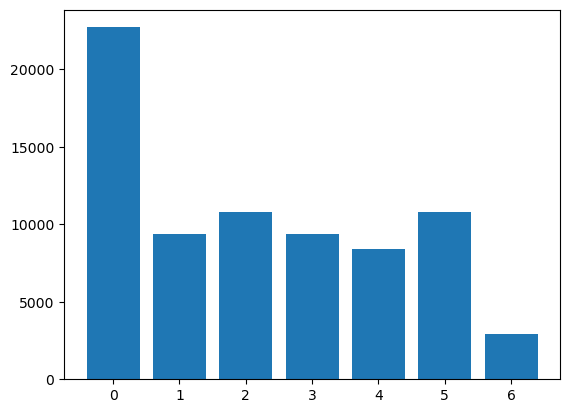

In [12]:
from collections import Counter

plt.bar(Counter(y_trainvaltest).keys(),Counter(y_trainvaltest).values())

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV 1/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.686 total time=  21.5s
[CV 3/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), preprocessor__tfidf__sublinear_tf=True;, score=0.690 total time=  24.9s
[CV 2/3] END clf__C=0.3981071705534972, clf__class_weight=balanced, clf__penalty=l2, preprocessor__tfidf__binary=True, preprocessor__tfidf__max_df=0.5, preprocessor__tfidf__max_features=20000, preprocessor__tfidf__min_df=1, preprocessor__tfidf__ngram_range=(1, 1), p

RandomizedSearchCV(cv=3, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('tfidf',
                                                                               TfidfVectorizer(stop_words='english'),
                                                                               'text'),
                                                                              ('source',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['source']),
                                                                              ('page_rank',
                                                                               OneHotEncoder(handle_unknown='ignore'),
                                                                               ['page_rank'])])),
                                             ('clf',
                                              LinearSVC(dual=False,
                                                        max_iter=3000))]),...
                                        'clf__class_weight': ['balanced'],
                                        'clf__penalty': ['l1', 'l2'],
                                        'preprocessor__tfidf__binary': [True,
                                                                        False],
                                        'preprocessor__tfidf__max_df': [0.5,
                                                                        0.7,
                                                                        0.9],
                                        'preprocessor__tfidf__max_features': [15000,
                                                                              20000,
                                                                              30000],
                                        'preprocessor__tfidf__min_df': [1, 2, 5,
                                                                        10],
                                        'preprocessor__tfidf__ngram_range': [(1,
                                                                              1),
                                                                             (1,
                                                                              3)],
                                        'preprocessor__tfidf__sublinear_tf': [True,
                                                                              False]},
                   scoring='f1_macro', verbose=3)

0.6890883362128548 {'preprocessor__tfidf__sublinear_tf': True, 'preprocessor__tfidf__ngram_range': (1, 1), 'preprocessor__tfidf__min_df': 1, 'preprocessor__tfidf__max_features': 20000, 'preprocessor__tfidf__max_df': 0.5, 'preprocessor__tfidf__binary': True, 'clf__penalty': 'l2', 'clf__class_weight': 'balanced', 'clf__C': np.float64(0.3981071705534972)}


0.7000722096643649
[[3371  163   78  206   73  541  112]
 [  96 1484  108   60   21   66   46]
 [  86  148 1762   63   15   44   36]
 [ 225  109  105 1000  147  234   49]
 [  19    8    5   52 1558   41    2]
 [ 545  122   67  218  125 1004   85]
 [  40   22   14   23    6   33  440]]


In [ ]:
df_eval['title'] = df_eval['title'].str.casefold().str.strip()
df_eval['article'] = df_eval['article'].str.casefold().str.strip()
df_eval['source'] = df_eval['source'].str.casefold().str.strip()
df_eval.fillna('', inplace=True)

df_eval['text'] = 2 * df_eval['title']+  ' ' + df_eval['article']

X_eval = df_eval[['text', 'source', 'page_rank']]
 

In [17]:
submit = pd.DataFrame()
submit['Id'] = np.arange(len(df_eval))
submit['Predicted'] = best_model.predict(X_eval)
submit.to_csv('./submission.csv', sep=',', index=False)

In [18]:
y_pred = best_model.predict(X_trainval)
print(f1_score(y_trainval, y_pred, average='macro'))

0.8680250470395371


              precision    recall  f1-score   support

           0       0.74      0.77      0.76      4382
           1       0.79      0.72      0.75      2056
           2       0.82      0.82      0.82      2139
           3       0.54      0.62      0.57      1622
           4       0.92      0.80      0.86      1945
           5       0.46      0.51      0.49      1963
           6       0.76      0.57      0.65       770

    accuracy                           0.71     14877
   macro avg       0.72      0.69      0.70     14877
weighted avg       0.72      0.71      0.72     14877



In [20]:
'''
3981a767685a14497b876a659d34f60f08feaff2bc9addc69818a1ceb27a04ac
'''

'\n3981a767685a14497b876a659d34f60f08feaff2bc9addc69818a1ceb27a04ac\n'